# ROM-SHRED Tutorial on Kuramoto Sivashinsky

#### Import Libraries

In [93]:
# PYSHRED
%load_ext autoreload
%autoreload 2
from pyshred import ParametricDataManager, SHRED, ParametricSHREDEngine

# Other helper libraries
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Kuramoto Sivashinsky dataset

In [94]:
import numpy as np
import urllib.request
# URL of the NPZ file
url = 'https://zenodo.org/records/14524524/files/KuramotoSivashinsky_data.npz?download=1'
# Local filename to save the downloaded file
filename = 'KuramotoSivashinsky_data.npz'
# Download the file from the URL
urllib.request.urlretrieve(url, filename)
# Load the data from the NPZ file
dataset = np.load(filename)

#### Initialize Data Manager

In [95]:
# Initialize ParametricSHREDDataManager
manager = ParametricDataManager(
    lags = 21,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    )

#### Add datasets and sensors

In [96]:
data = dataset['u'] # shape (500, 201, 100)
data_spatial_shape = data.shape[2:]
# mu = dataset['mu'] # shape (500, 201, 2)

manager.add_data(
    data=data,
    # random=3,
    stationary=[(15,),(30,),(45,)],
    # params=mu,
    id = 'KS',
    compress = False
)

#### Analyze sensor summary

In [97]:
manager.sensor_measurements_df

,KS-0,KS-1,KS-2
0,0.154032,-1.140074,-0.006130
1,0.332515,-1.079287,-0.023609
2,0.361393,-1.070717,0.002758
3,0.404951,-1.049306,0.015024
4,0.485893,-1.031259,0.017951
...,...,...,...
100495,0.261712,-1.793277,-0.135204
100496,-0.622521,-1.301706,0.021596
100497,-1.591052,-0.838068,0.158474
100498,-2.129965,-0.466887,0.281114


In [98]:
manager.sensor_summary_df

,data id,sensor_number,type,loc/traj
0,KS,0,stationary,"(15,)"
1,KS,1,stationary,"(30,)"
2,KS,2,stationary,"(45,)"


#### Get train, validation, and test set

In [99]:
train_dataset, val_dataset, test_dataset= manager.prepare()

#### Initialize SHRED

When using a `ParametricDataManager`, ensure `latent_forecaster` is set to None.

In [100]:
shred = SHRED(sequence_model="LSTM", decoder_model="MLP", latent_forecaster=None)

#### Fit SHRED

In [101]:
val_errors = shred.fit(train_dataset=train_dataset, val_dataset=val_dataset, num_epochs=5, sindy_regularization=0)
print('val_errors:', val_errors)

Fitting SHRED...
Epoch 1: Average training loss = 0.023503
Validation MSE (epoch 1): 0.015884
Epoch 2: Average training loss = 0.011217
Validation MSE (epoch 2): 0.013228
Epoch 3: Average training loss = 0.009117
Validation MSE (epoch 3): 0.010834
Epoch 4: Average training loss = 0.007808
Validation MSE (epoch 4): 0.009817
Epoch 5: Average training loss = 0.006982
Validation MSE (epoch 5): 0.008005
val_errors: [0.01588413 0.01322768 0.01083446 0.00981664 0.0080053 ]


#### Evaluate SHRED

In [102]:
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Train MSE: 0.006
Val   MSE: 0.008
Test  MSE: 0.005


#### Initialize Parametric SHRED Engine for Downstream Tasks (TODO)

In [103]:
engine = ParametricSHREDEngine(manager, shred)

#### Sensor Measurements to Latent Space

In [104]:
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

#### Decode Latent Space to Full-State Space

In [105]:
test_prediction = engine.decode(test_latent_from_sensors) # latent space generated from sensor data

Compare prediction against the truth

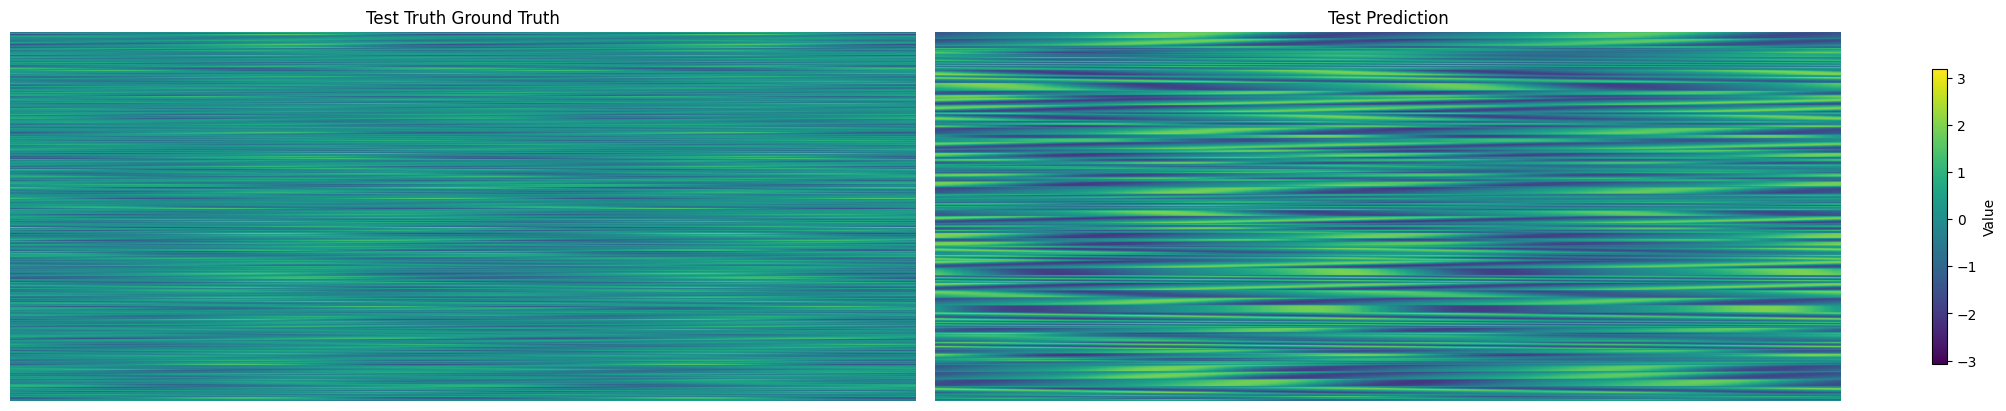

In [110]:
spatial_shape = data.shape[2:]
truth      = data.reshape(-1, *spatial_shape)
prediction = test_prediction['KS']

compare_data = [truth, prediction]
titles = ["Test Truth Ground Truth", "Test Prediction"]

vmin, vmax = np.min([d.min() for d in compare_data]), np.max([d.max() for d in compare_data])

fig, axes = plt.subplots(1, 2, figsize=(20, 4), constrained_layout=True)

for ax, d, title in zip(axes, compare_data, titles):
    im = ax.imshow(d, vmin=vmin, vmax=vmax, aspect='auto')
    ax.set(title=title)
    ax.axis("off")

fig.colorbar(im, ax=axes, label="Value", shrink=0.8)

#### Evaluate MSE on Ground Truth Data

Since both number of trajectories (`data.shape[0]`) and number of timesteps (`data.shape[1]`) are both variable, we will leave them combined on the first axis. The remaining axes are all spatial dimensions.

In [111]:
# Train
t_train = len(manager.train_sensor_measurements)
train_Y = {'KS': data[0:t_train].reshape(-1, *spatial_shape)} # unpack the spatial dimensions
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# Val
t_val = len(manager.test_sensor_measurements)
val_Y = {'KS': data[t_train:t_train+t_val].reshape(-1, *spatial_shape)}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# Test
t_test = len(manager.test_sensor_measurements)
test_Y = {'KS': data[-t_test:].reshape(-1, *spatial_shape)}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

print('---------- TRAIN ----------')
print(train_error)
print('\n---------- VAL   ----------')
print(val_error)
print('\n---------- TEST  ----------')
print(test_error)

---------- TRAIN ----------
             MSE      RMSE      MAE        R2
dataset                                      
KS       0.18685  0.432262  0.27461  0.857352

---------- VAL   ----------
              MSE      RMSE       MAE        R2
dataset                                        
KS       0.270706  0.520294  0.336177  0.789836

---------- TEST  ----------
              MSE      RMSE       MAE        R2
dataset                                        
KS       0.168299  0.410243  0.252061  0.872379
